In [65]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import unidecode
import string

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

import time
import os
import sys

In [70]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

## Lectura de datos

In [66]:
# time taken to read data
s_time = time.time()
df = pd.read_csv("~/Documents/projects/nlp/unsuperv_classifier_news/BD_notas.csv", header=0)
e_time = time.time()
  
print("Read without chunks: ", (e_time-s_time), "seconds")


Read without chunks:  11.934394121170044 seconds


## Muestra del mes de Julio 2021

In [67]:
# Convert the date to datetime64
df['fecha_publicacion'] = pd.to_datetime(df['fecha_publicacion'], format='%Y-%m-%d')
  
# Filter data between two dates
july_notes_df = pd.DataFrame(df.loc[(df['fecha_publicacion'] >= '2021-07-01')
                     & (df['fecha_publicacion'] <= '2021-07-31')])
  
# Display
print("\nPosts en Julio 2021:")
len(july_notes_df)
print("Muestra de una nota en la columna contenido")
print(july_notes_df["contenido"][0])


Posts en Julio 2021:
Muestra de una nota en la columna contenido
['<b>Esta noche se vivió la sexta gala de “</b><a href="https://elcomercio.pe/noticias/reinas-del-show/?ref=ecr" target="_blank"><b>Reinas del Show</b></a><b>” y tras las presentaciones de todas las participantes se conoció quienes serían las sentenciadas de la noche.</b>' 'Fue Korina Rivadeneira quien obtuvo el mayor puntaje del jurado con 41 puntos y los mejores pasos de la noche. Mientras que<b> Jossmery Toledo </b>se convirtió en la tercera eliminada del espacio de<b> América TV.</b>' '<i><b>Mira esto: </b></i><a href="https://elcomercio.pe/tvmas/farandula/jossmery-toledo-es-eliminada-y-abandona-reinas-del-show-video-gisela-valcarcel-farandula-nndc-noticia/"><i><b>Jossmery Toledo es eliminada y abandona “Reinas del Show” | VIDEO</b></i></a>' '<a href="https://elcomercio.pe/noticias/jamzin-pinedo/?ref=ecr" target="_blank"><b>Jazmin Pinedo</b></a><b> </b><a href="https://elcomercio.pe/noticias/opaula-manzanal/?ref=ecr"

## Limpieza de datos

In [68]:
# adding more stopwords
stop_words = stopwords.words('spanish')
_new_stopwords_to_add = ["TE PUEDE", "TE", "PUEDE", "RECOMENDADO", "VIDEO","VIDEO RECOMENDADO", "PUEDE INTERESAR", "INTERESAR", "Sin embargo", "Además", "fue", "recomendado", "interesar", "video recomendado", "dijo", "además", "luego", "video", "también", "tambien", "mientras", "como", "solo", "lo", "en", "si", "la", "tras"]
stop_words.extend(_new_stopwords_to_add)

In [71]:
def preprocessing_text(text, flg_lemm=True, flg_stemm=False, lst_stopwords=None):
 
    #Deleting html
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = "".join(filter(lambda x: x not in ["“", "”", "‘", "’"], text))
    text = text.replace('\\t', '')
    text = text.replace('\\n', '')
    
    #Removing punctuation 
    no_punctuation = text.translate(str.maketrans('', '', string.punctuation))

    #Removing numbers
    no_numbers = "".join(filter(lambda x: not x.isdigit(), no_punctuation))
    
    #Removing emojies
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags 
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', no_numbers)

    
    #Tokenizing
    tokenized_text = emoji_pattern.split()
    
    #Deleting stopwords
    if lst_stopwords is not None:
        no_stopwords = [word for word in tokenized_text if word not in 
                    lst_stopwords]
    
    #Deleting words including "icon"
    icon_deleted = [x for x in no_stopwords if "icon" not in x ]
    
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        ps = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [ps.lemmatize(word) for word in icon_deleted]
    
    ## Stemming
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in icon_deleted]

 
    ## back to string from list
    clean_text = " ".join(lst_text) 
  
    #Removing ascents and lowering
    clean_text = unidecode.unidecode(clean_text).lower()
    
    return clean_text

In [72]:
july_notes_df["contenido"] = july_notes_df["contenido"].apply(lambda x: 
                              preprocessing_text(x, flg_lemm=True, flg_stemm=False,
                              lst_stopwords=stop_words))
july_notes_df["titulo_nota"] = july_notes_df["titulo_nota"].apply(lambda x: 
                              preprocessing_text(x, flg_lemm=True, flg_stemm=False,
                              lst_stopwords=stop_words))

/home/gloria/anaconda3/envs/unsuperv_classifier_news/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [73]:
notes_titles = list(july_notes_df["contenido"]) + list(july_notes_df["titulo_nota"])
print(len(notes_titles))

19938


In [74]:
# Muestra de texto preprocesada
notes_titles[0]

'esta noche vivio sexta gala reinas show presentaciones toda participantes conocio sentenciadas noche fue korina rivadeneira obtuvo mayor puntaje jurado puntos mejores pasos noche mientras jossmery toledo convirtio tercera eliminada espacio america tv mira jossmery toledo eliminada abandona reinas show jazmin pinedo paula manzanal allison pastor quedaron cuerda floja semana esposa erick elera salvada jurado por lado paula manzanal protagonizo emotivo momento contar hijo reclama pasa tiempo trabajo reinas show cabe senalar sexta edicion reality america tv conducido gisela valcarcel participan belen estevez morella petrozzi santi lesmes carlos cacho jurado sentenciadas quinta gala reinas show'

In [75]:
with open('july_data.txt', 'w') as f:
    for item in notes_titles:
        f.write("%s\n" % item)

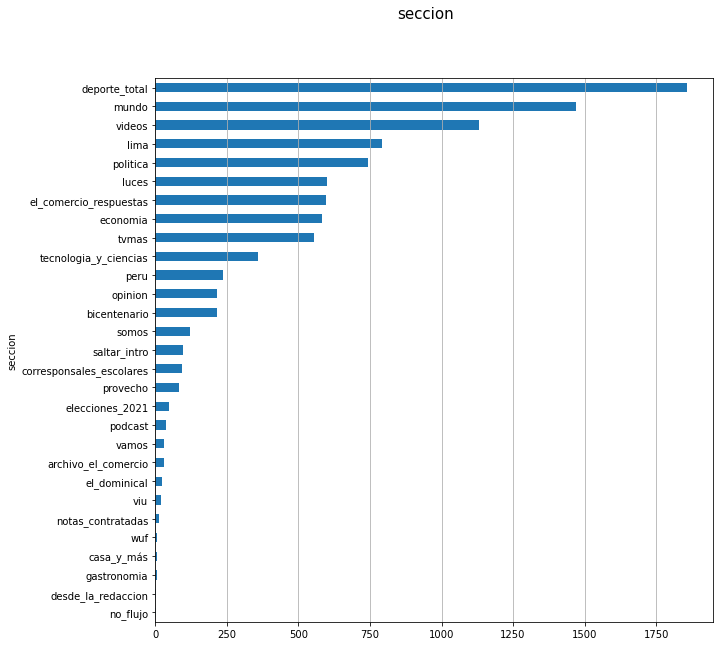

['tvmas' 'deporte_total' 'economia' 'videos' 'lima' 'mundo' 'peru'
 'politica' 'luces' 'somos' 'el_comercio_respuestas'
 'tecnologia_y_ciencias' 'desde_la_redaccion' 'opinion'
 'archivo_el_comercio' 'provecho' 'saltar_intro' 'podcast' 'el_dominical'
 'gastronomia' 'viu' 'vamos' 'corresponsales_escolares' 'bicentenario'
 'notas_contratadas' 'wuf' 'elecciones_2021' 'casa_y_más' 'no_flujo']


In [90]:
x = "seccion"
fig, ax = plt.subplots()
#fig(figsize=(8, 6), dpi=80)
fig.suptitle(x, fontsize=15)
july_notes_df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()
print(july_notes_df["seccion"].unique())

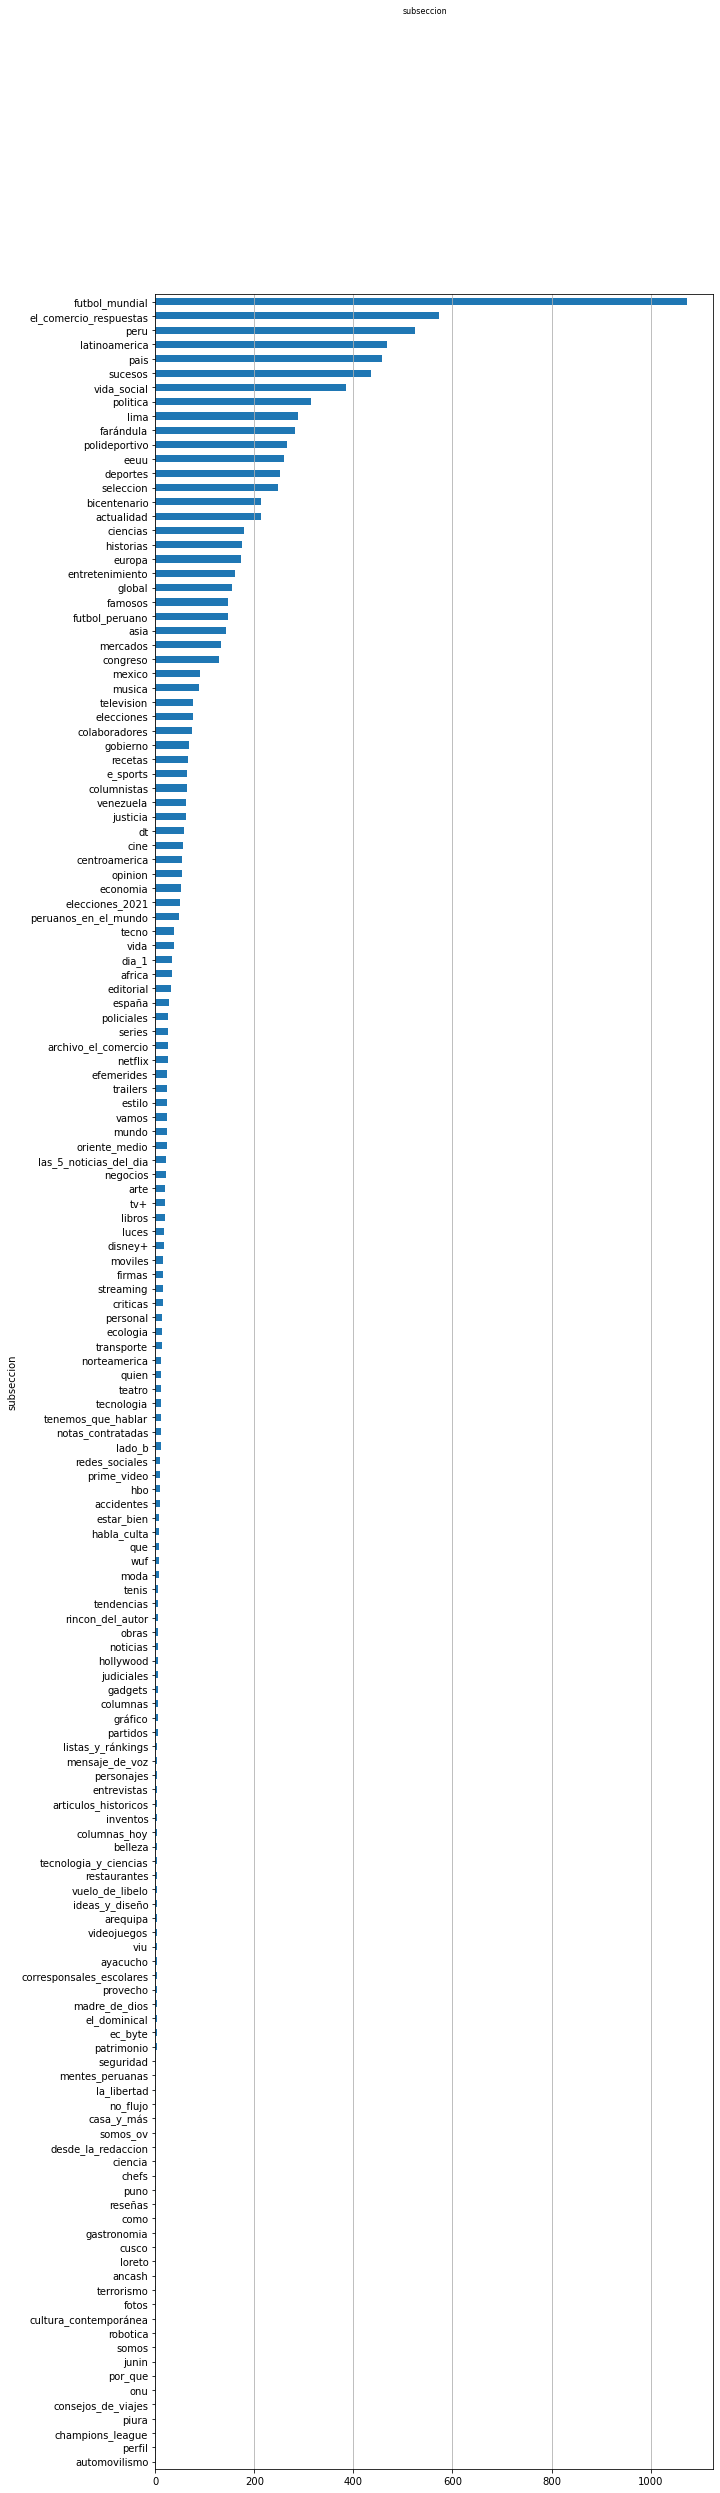

['farándula' 'polideportivo' 'mercados' 'tv+' 'economia' 'entretenimiento'
 'television' 'lima' 'futbol_mundial' 'actualidad' 'peruanos_en_el_mundo'
 'peru' 'latinoamerica' 'deportes' 'congreso' 'dt' 'musica' 'vida_social'
 'historias' 'africa' 'el_comercio_respuestas' 'eeuu' 'gobierno'
 'politica' 'sucesos' 'ciencias' 'redes_sociales' 'pais' 'seleccion'
 'famosos' 'centroamerica' 'futbol_peruano' 'mexico' 'global' 'vida'
 'desde_la_redaccion' 'asia' 'europa' 'cine' 'editorial' 'dia_1'
 'archivo_el_comercio' 'lado_b' 'mundo' 'firmas' 'libros'
 'listas_y_ránkings' 'columnistas' 'entrevistas' 'luces' 'colaboradores'
 'efemerides' 'justicia' 'arte' 'tendencias' 'transporte' 'que'
 'venezuela' 'series' 'streaming' 'piura' 'oriente_medio' 'disney+'
 'teatro' 'chefs' 'recetas' 'estilo' 'españa' 'opinion'
 'las_5_noticias_del_dia' 'criticas' 'personajes' 'policiales'
 'mensaje_de_voz' 'judiciales' 'ecologia' 'moviles' 'e_sports' 'ayacucho'
 'somos' 'norteamerica' 'tecno' 'restaurantes' 'habla

In [88]:
x = "subseccion"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=8)
july_notes_df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.rcParams["figure.figsize"] = (10,40)
plt.show()
print(july_notes_df["subseccion"].unique())

## Examining categories csv file

In [78]:
categorias = pd.read_excel("~/Documents/projects/nlp/unsuperv_classifier_news/Diccionario_Categorias.xlsx", skiprows = 0)
categorias["/Adult"]= pd.DataFrame(x[1:] for x in categorias["/Adult"])
categorias["/Adult"] = categorias["/Adult"].str.split("/")

In [79]:
categorias

,/Adult
0,[Arts & Entertainment]
1,"[Arts & Entertainment, Celebrities & Entertain..."
2,"[Arts & Entertainment, Comics & Animation]"
3,"[Arts & Entertainment, Comics & Animation, Ani..."
4,"[Arts & Entertainment, Comics & Animation, Car..."
...,...
614,"[Travel, Tourist Destinations, Beaches & Islands]"
615,"[Travel, Tourist Destinations, Mountain & Ski ..."
616,"[Travel, Tourist Destinations, Regional Parks ..."
617,"[Travel, Tourist Destinations, Theme Parks]"


In [84]:
# function to get unique values
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

a =[]
for i in range(0, len(categorias)):
    a.append(categorias["/Adult"][i][0])

# 26 categorias generales
unique(a)

['Arts & Entertainment' 'Autos & Vehicles' 'Beauty & Fitness'
 'Books & Literature' 'Business & Industrial' 'Computers & Electronics'
 'Finance' 'Food & Drink' 'Games' 'Health' 'Hobbies & Leisure'
 'Home & Garden' 'Internet & Telecom' 'Jobs & Education'
 'Law & Government' 'News' 'Online Communities' 'People & Society'
 'Pets & Animals' 'Real Estate' 'Reference' 'Science' 'Sensitive Subjects'
 'Shopping' 'Sports' 'Travel']
